In [1]:
from google.colab import files
uploaded = files.upload()

Saving log_sequence_matrix.joblib to log_sequence_matrix.joblib
Saving classified_logs.csv to classified_logs.csv


In [2]:
import joblib
import numpy as np

X = joblib.load("log_sequence_matrix.joblib")
print("✅ Feature matrix shape:", X.shape)


✅ Feature matrix shape: (56480, 100)


In [5]:
import pandas as pd

df = pd.read_csv("classified_logs.csv")
print("📄 Available columns in classified_logs.csv:")
print(df.columns)
df.head()


📄 Available columns in classified_logs.csv:
Index(['LineId', 'Time', 'Level', 'Content', 'EventId', 'EventTemplate'], dtype='object')


,LineId,Time,Level,Content,EventId,EventTemplate
0,1,Thu Jun 09 06:07:04 2005,notice,LDAP: Built with OpenLDAP LDAP SDK,E17,LDAP: <*>
1,2,Thu Jun 09 06:07:04 2005,notice,LDAP: SSL support unavailable,E17,LDAP: <*>
2,3,Thu Jun 09 06:07:04 2005,notice,suEXEC mechanism enabled (wrapper: /usr/sbin/s...,E19,suEXEC mechanism enabled (wrapper: <*>)
3,4,Thu Jun 09 06:07:05 2005,notice,Digest: generating secret for digest authentic...,E18,Digest: <*>
4,5,Thu Jun 09 06:07:05 2005,notice,Digest: done,E18,Digest: <*>


In [7]:
import pickle

# Adjust file name if needed
with open("/content/windowed_sequences (3).pkl", "rb") as f:
    windowed_sequences = pickle.load(f)

print(f" Loaded {len(windowed_sequences)} sequences")
print(" Sample:", windowed_sequences[0])


 Loaded 56480 sequences
 Sample: ['E17', 'E17', 'E19']


In [9]:
# Label as 1 if the sequence contains any anomaly event ID
anomaly_events = ['E10', 'E11', 'E12']

y_labels = [1 if any(event in anomaly_events for event in seq) else 0 for seq in windowed_sequences]

print(f" Created {len(y_labels)} labels")
print(f" Anomalies: {sum(y_labels)}, Normals: {len(y_labels) - sum(y_labels)}")


 Created 56480 labels
 Anomalies: 225, Normals: 56255


In [10]:
assert len(X) == len(y_labels), " Mismatch between features and labels"


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_labels, test_size=0.3, stratify=y_labels, random_state=42)

print("Split complete. Train:", len(X_train), "Test:", len(X_test))


Split complete. Train: 39536 Test: 16944


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(),
    "C-SVC": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f" Trained {name}")


 Trained Logistic Regression
 Trained C-SVC
 Trained Random Forest


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:41:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Trained XGBoost


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n {name}")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", cm)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

df_results = pd.DataFrame(results)
df_results.to_csv("supervised_model_comparison.csv", index=False)
print(" Saved: supervised_model_comparison.csv")



 Logistic Regression
Accuracy: 0.9975212464589235
Precision: 0.6344086021505376
Recall: 0.8805970149253731
F1 Score: 0.7375
Confusion Matrix:
 [[16843    34]
 [    8    59]]

 C-SVC
Accuracy: 0.9992917847025495
Precision: 0.9365079365079365
Recall: 0.8805970149253731
F1 Score: 0.9076923076923077
Confusion Matrix:
 [[16873     4]
 [    8    59]]

 Random Forest
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[16877     0]
 [    0    67]]

 XGBoost
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[16877     0]
 [    0    67]]
 Saved: supervised_model_comparison.csv



 Logistic Regression
Accuracy: 0.9975
Precision: 0.6344
Recall: 0.8806
F1 Score: 0.7375


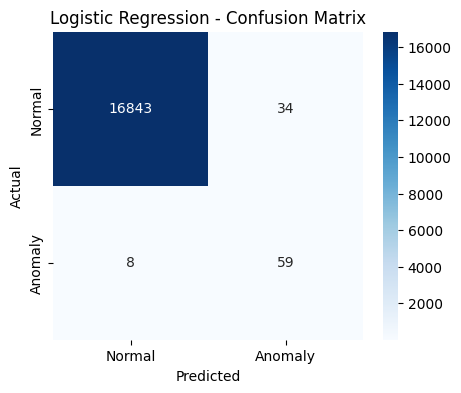


 C-SVC
Accuracy: 0.9993
Precision: 0.9365
Recall: 0.8806
F1 Score: 0.9077


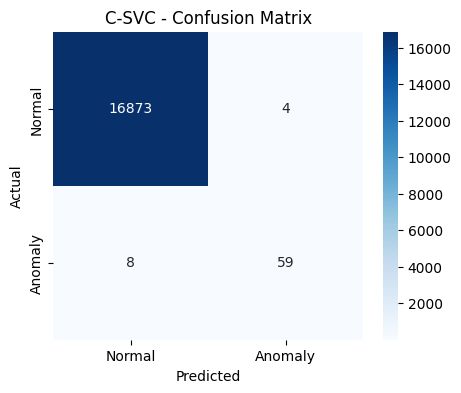


 Random Forest
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


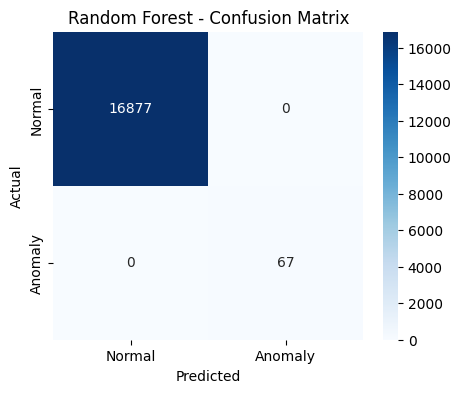


 XGBoost
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


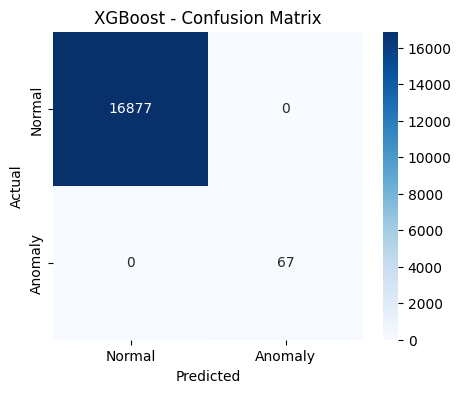

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n {name}")
    print("Accuracy:", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall:", round(rec, 4))
    print("F1 Score:", round(f1, 4))

    # Save metrics
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


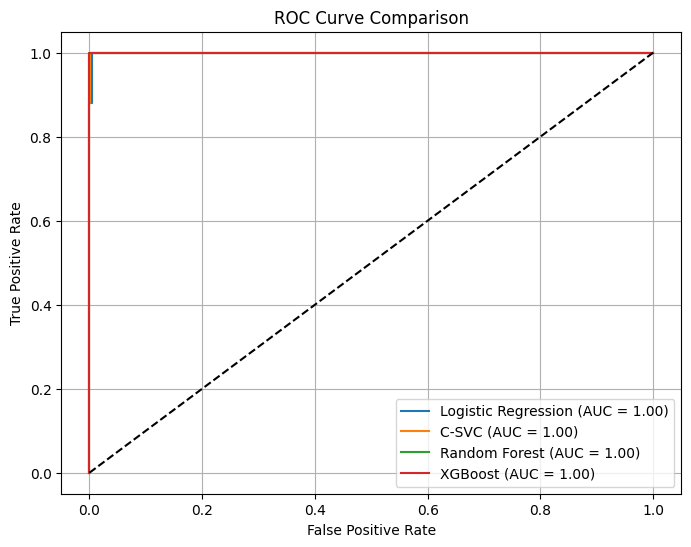

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [20]:
best_model = models["XGBoost"]
y_pred = best_model.predict(X_test)

pd.DataFrame({
    "true_label": y_test,
    "predicted": y_pred
}).to_csv("supervised_predictions.csv", index=False)

print("✅ Saved: supervised_predictions.csv")


✅ Saved: supervised_predictions.csv
